In [ ]:
!pip install trimesh

In [ ]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/draping_workspace'       # path to your project on Drive

drive.mount(ROOT)

Mounted at /content/drive


In [ ]:
import trimesh
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import torch

In [ ]:
tool_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/0018_rig000.obj',process=False)
fabric_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/0018_000.obj',process=False)

In [ ]:
tool_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/0040_rig000.obj',process=False)
fabric_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/0040_000.obj',process=False)

In [ ]:
scene = trimesh.Scene([tool_mesh, fabric_mesh])
scene.show(viewer='notebook')

In [ ]:
torch_fabric_v = torch.tensor(fabric_mesh.vertices)
torch_fabric_f = torch.tensor(fabric_mesh.faces)

torch_tool_v = torch.tensor(tool_mesh.vertices)
torch_tool_f = torch.tensor(tool_mesh.faces)

(array([235.,   7.,   3.,   1.,   5.,   1.,   0.,   0.,   1., 354.]),
 array([1.39274381e-62, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

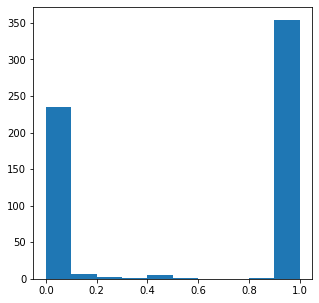

In [ ]:
z_dists = torch.nn.functional.relu((torch_fabric_v - torch_tool_v)[:,2])
thresh = 1e-3
weights = torch.exp(-z_dists/thresh)
plt.rcParams["figure.figsize"] = (5,5)
plt.hist(weights)

In [ ]:
xy = torch_fabric_v[:,0:2]
contact = xy[weights>0.99]
noncontact = xy[weights<0.99]

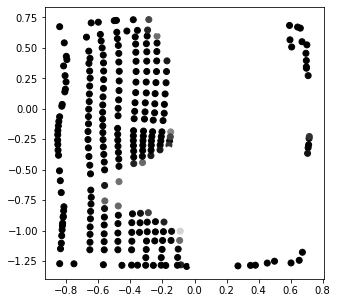

In [ ]:
plt.scatter(xy[:,0].numpy(), xy[:,1].numpy(), c=weights.numpy(), cmap='gray')

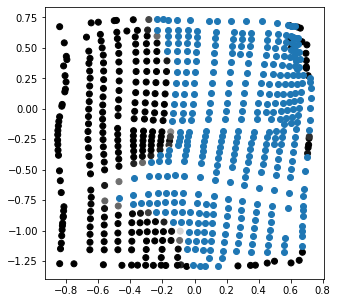

In [ ]:
plt.scatter(xy[:,0].numpy(), xy[:,1].numpy(), c=weights.numpy(), cmap='gray')
plt.scatter(contact[:,0].numpy(), contact[:,1].numpy())

In [ ]:
A = xy
C = A.mean(dim=(-2,), keepdim=True)
U,S,V = torch.svd(A - C)
P2 = torch.matmul(A, V[:, :2])
P1 = torch.matmul(A, V[:, :1])

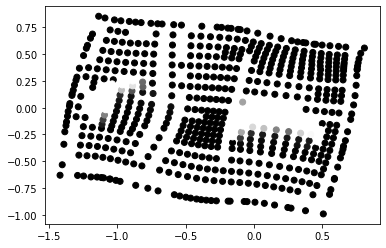

In [ ]:
plt.scatter(P2[:,0], P2[:,1], c=weights.numpy(), cmap='gray')

In [ ]:
plt.scatter(p[:,0],weights)

NameError: name 'p' is not defined

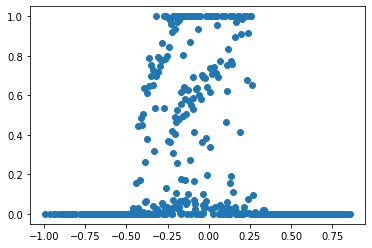

In [ ]:
plt.scatter(p[:,1],weights)

(array([15.,  5.,  0.,  0.,  0.,  0.,  9.,  6.,  6.,  8.]),
 array([-1.21907424, -1.04815379, -0.87723334, -0.70631289, -0.53539244,
        -0.364472  , -0.19355155, -0.0226311 ,  0.14828935,  0.3192098 ,
         0.49013024]),
 <a list of 10 Patch objects>)

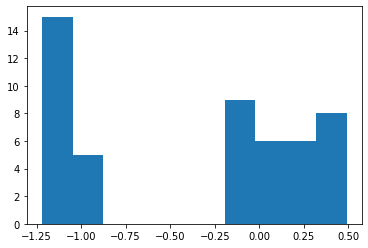

In [ ]:
plt.hist(p[weights>0.99,0])

In [ ]:
def get_moments(d):
    mean = torch.mean(d,0,keepdim=True)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0),0,keepdim=True)
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0),0,keepdim=True)
    kurtoses = torch.mean(torch.pow(zscores, 4.0),0,keepdim=True)
    return torch.cat((mean,std,skews,kurtoses)).transpose(1,0)

def pca(xy):
    A = xy
    #center
    C = A.mean(dim=(-2,), keepdim=True)
    U,S,V = torch.svd(A - C)
    #project onto principal components
    P2 = torch.matmul(A, V[:, :2])
    P1 = torch.matmul(A, V[:, :1])
    return P2

def test(moments):
    #BC multimodality test
    skewness = moments[:,2]
    kurtoses = moments[:,3]
    return (skewness**2 + 1)/kurtoses

z_dists = torch.nn.functional.relu((torch_fabric_v - torch_tool_v)[:,2])
thresh = 1e-2
weights = torch.exp(-z_dists/thresh)

xy = torch_fabric_v[:,0:2]

loss = 0

if(torch.any(weights > 0.99)):
    p = pca(xy)
    m = get_moments(p[weights>0.99])
    max_bc = torch.logsumexp(test(m)*1e1,dim=0)/1e1 #higher is worse
    loss += torch.exp(10*((max_bc - 0.555)/0.445))
    
print(loss)

tensor(214.0596, dtype=torch.float64)


In [ ]:
import networkx as nx
from itertools import product

G = nx.Graph()
G.add_edges_from(fabric_mesh.edges_unique)
P = dict(nx.all_pairs_shortest_path(G))

mod_weights = torch.tensor(weights)
# mod_weights[mod_weights < 0.99] = 0
# mod_weights[mod_weights > 0.99] = 1

vertex_connectivity = torch.zeros(fabric_mesh.vertices.shape[0])

for i in range(fabric_mesh.vertices.shape[0]):
    for j in range(fabric_mesh.vertices.shape[0]):
        vertex_connectivity[i] += mod_weights[P[i][j]].prod()

vertex_connectivity.sum()/mod_weights.sum()

tensor(343.7611, dtype=torch.float64)

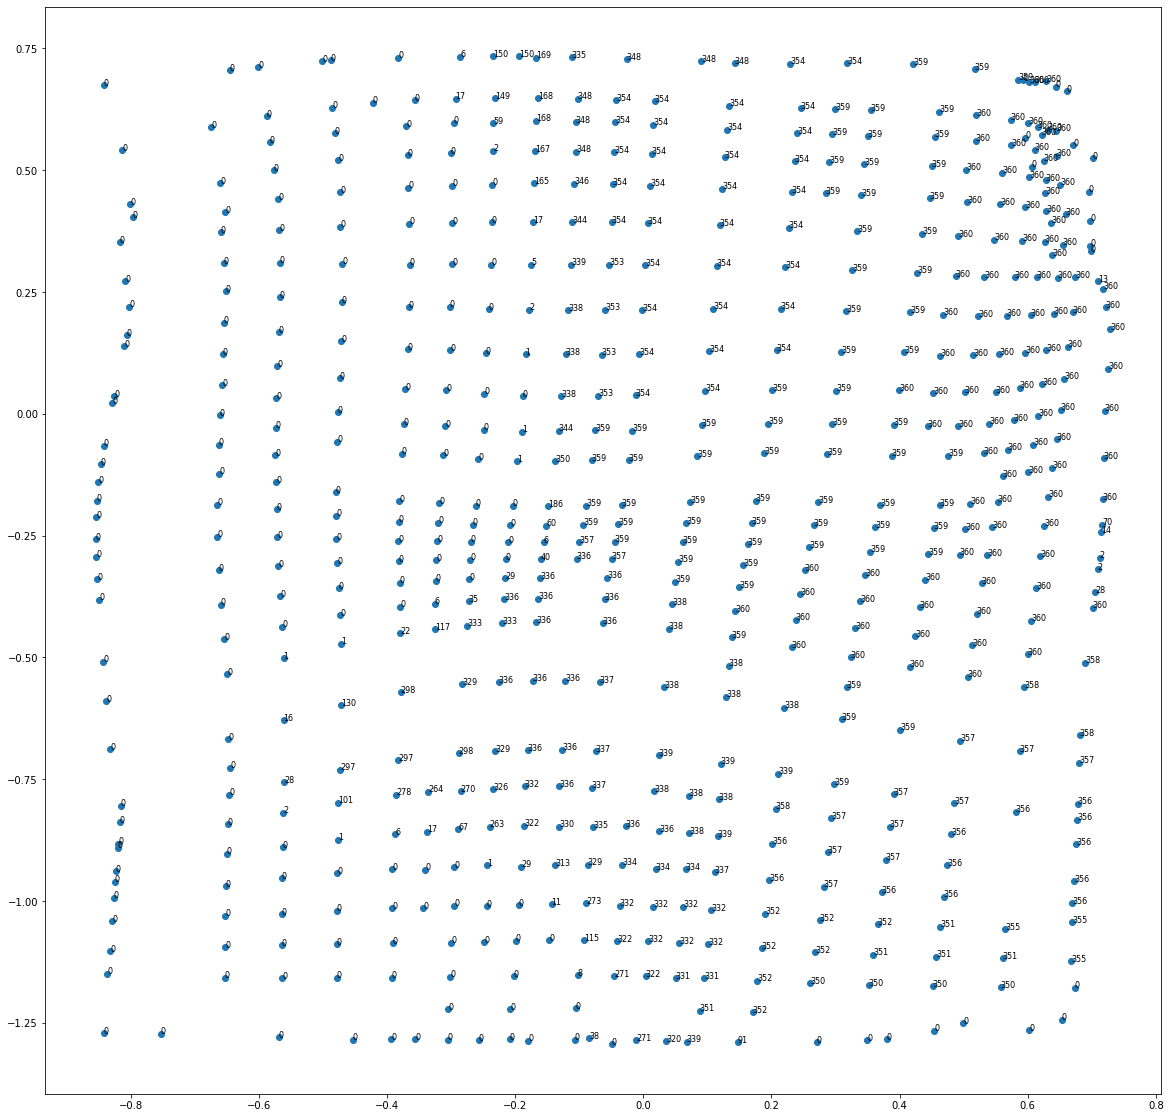

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)
plt.scatter(xy[:,0].numpy(), xy[:,1].numpy())
for i in range(fabric_mesh.vertices.shape[0]):
    plt.text(fabric_mesh.vertices[i,0], fabric_mesh.vertices[i,1], f'{vertex_connectivity[i]:.0f}',fontsize=8)

In [ ]:
import networkx as nx
A = nx.adjacency_matrix(fabric_mesh.vertex_adjacency_graph)
A = torch.tensor(A.todense())
A = (A*weights).numpy()
A[A < 0.99] = 0
A[A > 0.99] = 1


In [ ]:
# create the graph laplacian
D = np.diag(A.sum(axis=1))
L = D-A

# find the eigenvalues and eigenvectors
vals, vecs = np.linalg.eig(L)

# sort
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]